In [1]:
import os
import numpy as np
import pandas as pd
from pycocotools.coco import COCO
from collections import defaultdict

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Loading COCO metadata

In [2]:

# !!! SET THE CORRECT PATH TO YOUR FILES AND FOLDERS !!!

train_annot_path = '../datasets/coco_2017_dataset/annotations/person_keypoints_train2017.json'
train_img_path = '../datasets/coco_2017_dataset/train2017/'

val_annot_path = '../datasets/coco_2017_dataset/annotations/person_keypoints_val2017.json'
val_img_path = '../datasets/coco_2017_dataset/val2017/'

train_coco = COCO(train_annot_path)
val_coco = COCO(val_annot_path)

loading annotations into memory...
Done (t=7.88s)
creating index...
index created!
loading annotations into memory...
Done (t=0.90s)
creating index...
index created!


Utility functions to convert COCO data to pandas dataframes. 

In [3]:
def get_meta(coco):
    ids = list(coco.imgs.keys())
    for i, img_id in enumerate(ids):
        img_meta = coco.imgs[img_id]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        img_file_name = img_meta['file_name']
        w = img_meta['width']
        h = img_meta['height']
        
        yield [img_id, img_file_name, w, h, anns]
        
def convert_to_df(coco):
    images_data = []
    persons_data = []
    
    for img_id, img_fname, w, h, meta in get_meta(coco):
        images_data.append({
            'image_id': int(img_id),
            'path': img_fname,
            'width': int(w),
            'height': int(h)
        })
        for m in meta: 
            persons_data.append({
                'image_id': m['image_id'],
                'is_crowd': m['iscrowd'],
                'bbox': m['bbox'],
                'area': m['area'],
                'num_keypoints': m['num_keypoints'],            
                'keypoints': m['keypoints'],            
            })
    
    images_df = pd.DataFrame(images_data) 
    images_df.set_index('image_id', inplace=True)

    persons_df = pd.DataFrame(persons_data) 
    persons_df.set_index('image_id', inplace=True)
    
    return images_df, persons_df        

## Convert COCO dataset format to DataFrames to simplify the analysis

Merge dataframes images and annotations for training set.

In [4]:
images_df, persons_df = convert_to_df(train_coco)     
train_coco_df = pd.merge(images_df, persons_df, right_index=True, left_index=True)
train_coco_df['source'] = 0
train_coco_df.head()

,path,width,height,is_crowd,bbox,area,num_keypoints,keypoints,source
image_id,,,,,,,,,
36,000000000036.jpg,481,640,0,"[167.58, 162.89, 310.61, 465.19]",86145.29710,13,"[250, 244, 2, 265, 223, 2, 235, 235, 2, 309, 2...",0
49,000000000049.jpg,381,500,0,"[203.39, 260.43, 65.69, 73.04]",1754.81755,13,"[251, 276, 2, 253, 275, 2, 250, 274, 2, 259, 2...",0
49,000000000049.jpg,381,500,0,"[118.43, 261.32, 56.91, 62.93]",1349.98230,11,"[158, 270, 1, 160, 269, 2, 157, 269, 1, 167, 2...",0
49,000000000049.jpg,381,500,0,"[119.34, 334.21, 11.94, 33.57]",250.81990,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
49,000000000049.jpg,381,500,0,"[284.34, 333.4, 10.88, 27.43]",162.90005,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0


Merge dataframes images and annotations for validation set

In [5]:
images_df, persons_df = convert_to_df(val_coco)      
val_coco_df = pd.merge(images_df, persons_df, right_index=True, left_index=True)
val_coco_df['source'] = 1
val_coco_df.head()

,path,width,height,is_crowd,bbox,area,num_keypoints,keypoints,source
image_id,,,,,,,,,
139,000000000139.jpg,640,426,0,"[412.8, 157.61, 53.05, 138.01]",2913.11040,15,"[427, 170, 1, 429, 169, 2, 0, 0, 0, 434, 168, ...",1
139,000000000139.jpg,640,426,0,"[384.43, 172.21, 15.12, 35.74]",435.14495,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
785,000000000785.jpg,640,425,0,"[280.79, 44.73, 218.7, 346.68]",27789.11055,17,"[367, 81, 2, 374, 73, 2, 360, 75, 2, 386, 78, ...",1
872,000000000872.jpg,621,640,0,"[145.26, 100.67, 291.95, 457.35]",25759.04240,12,"[367, 138, 2, 0, 0, 0, 360, 134, 2, 0, 0, 0, 3...",1
872,000000000872.jpg,621,640,0,"[163.73, 126.42, 265.69, 480.4]",48091.75195,15,"[211, 187, 1, 215, 179, 2, 0, 0, 0, 241, 175, ...",1


Combine traininng set ('source' = 0) and validation set ('source' = 1).

In [6]:
coco_df = pd.concat([train_coco_df, val_coco_df], ignore_index=True)
coco_df

,path,width,height,is_crowd,bbox,area,num_keypoints,keypoints,source
0,000000000036.jpg,481,640,0,"[167.58, 162.89, 310.61, 465.19]",86145.29710,13,"[250, 244, 2, 265, 223, 2, 235, 235, 2, 309, 2...",0
1,000000000049.jpg,381,500,0,"[203.39, 260.43, 65.69, 73.04]",1754.81755,13,"[251, 276, 2, 253, 275, 2, 250, 274, 2, 259, 2...",0
2,000000000049.jpg,381,500,0,"[118.43, 261.32, 56.91, 62.93]",1349.98230,11,"[158, 270, 1, 160, 269, 2, 157, 269, 1, 167, 2...",0
3,000000000049.jpg,381,500,0,"[119.34, 334.21, 11.94, 33.57]",250.81990,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,000000000049.jpg,381,500,0,"[284.34, 333.4, 10.88, 27.43]",162.90005,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
...,...,...,...,...,...,...,...,...,...
273464,000000581357.jpg,612,612,0,"[180.89, 440.51, 21.1, 38.36]",371.49395,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
273465,000000581357.jpg,612,612,0,"[249.22, 419.65, 13.2, 24.53]",169.55635,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
273466,000000581357.jpg,612,612,0,"[211.18, 420.26, 23.38, 40.03]",542.16740,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
273467,000000581357.jpg,612,612,0,"[230.28, 420.86, 19.02, 37.35]",371.93055,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


## Show how many people are visible in a single image

Number of people in total: 268030
Number of crowd annotations: 5439


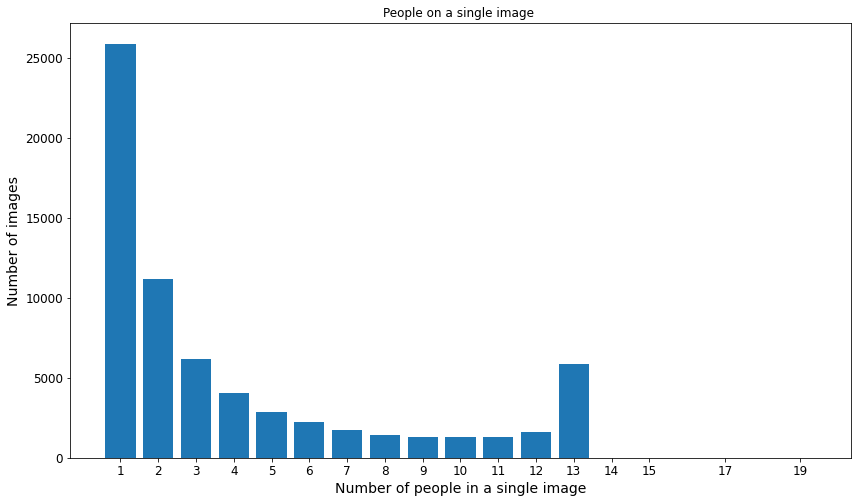

In [7]:
# count number of annotations per image

annotated_persons_df = coco_df[(coco_df['is_crowd'] == 0)]
crowd_df = coco_df[coco_df['is_crowd'] == 1]

print("Number of people in total: " + str(len(annotated_persons_df)))
print("Number of crowd annotations: " + str(len(crowd_df)))

persons_in_img_df = pd.DataFrame({
    'cnt': annotated_persons_df[['path','source']].value_counts()
})
persons_in_img_df.reset_index(level=[0,1], inplace=True) 

# group by counter so we will get the dataframe with number of annotated people
# in a single image

persons_in_img_cnt_df = persons_in_img_df.groupby(['cnt']).count()

# extract arrays

x_occurences = persons_in_img_cnt_df.index.values
y_images = persons_in_img_cnt_df['path'].values

# plot
f = plt.figure(figsize=(14, 8))
plt.bar(x_occurences, y_images)
plt.title('People on a single image ')
plt.xticks(x_occurences, x_occurences)
plt.xlabel('Number of people in a single image')
plt.ylabel('Number of images')
plt.show()

Utility functions for displaying images

In [8]:
def get_full_path(df, row = 0):
    path = df['path'].values[row]
    source = df['source'].values[row]
    if source == 0:
        return os.path.join(train_img_path, path)
    else:
        return os.path.join(val_img_path, path)    

Show a few examples of images with 13 annotated persons

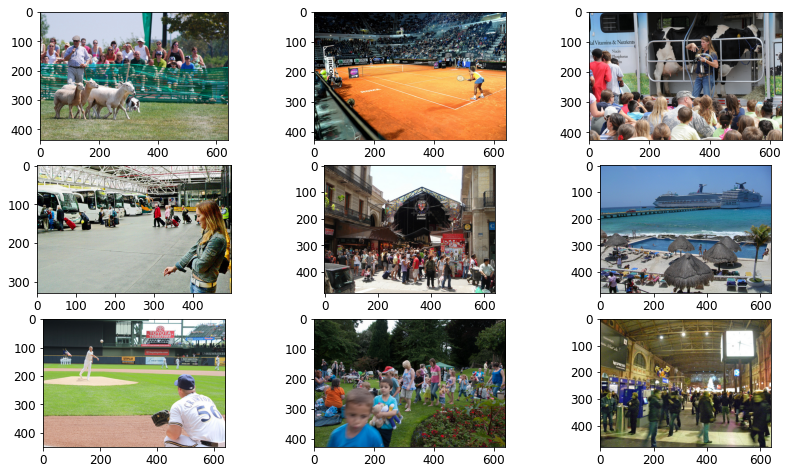

,path,source,cnt
58,000000288685.jpg,1,13
59,000000402615.jpg,1,13
61,000000114907.jpg,1,13
91,000000114884.jpg,1,13
174,000000290248.jpg,1,13
186,000000289741.jpg,1,13
225,000000282037.jpg,1,13
236,000000117492.jpg,1,13
265,000000282298.jpg,1,13


In [9]:
subset_df = persons_in_img_df[(persons_in_img_df['cnt'] == 13) & (persons_in_img_df['source'] == 1)]

# take only 9 images -> grid 3x3

subset_df = subset_df[:9]

# read images

full_paths = [get_full_path(subset_df, row = r) for r in range(len(subset_df))]
imgs = [mpimg.imread(path) for path in full_paths]

# plot

_, axs = plt.subplots(3, 3, figsize=(14, 8))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

subset_df

Image showing the largest number of annotated people = 19

,path,source,cnt
0,000000497261.jpg,0,19


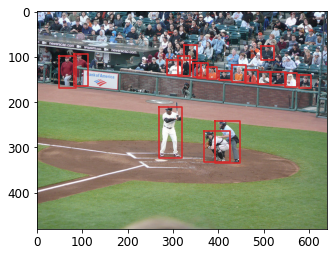

In [10]:
subset_df = persons_in_img_df[(persons_in_img_df['cnt'] == 19)]

path = get_full_path(subset_df)
img = mpimg.imread(path)
plt.imshow(img)

path = subset_df.loc[0, 'path']
source = subset_df.loc[0, 'source']
subset_full = coco_df[(coco_df['path'] == path) & (coco_df['source'] == source) & (coco_df['is_crowd'] == 0)]
bbox = np.array(subset_full['bbox'].values.tolist())
for r in bbox:
    x = [r[0], r[0] + r[2], r[0] + r[2], r[0], r[0]]
    y = [r[1], r[1], r[1] + r[3], r[1] + r[3], r[1]]
    plt.plot(x, y, color ='tab:red')      

subset_df

There exists annotations that are very small, possible without any keypoints.

Show statistics of images with persons having some keypoints

Number of people (with keypoints) in total: 156165
Number of people without any keypoints in total: 111865


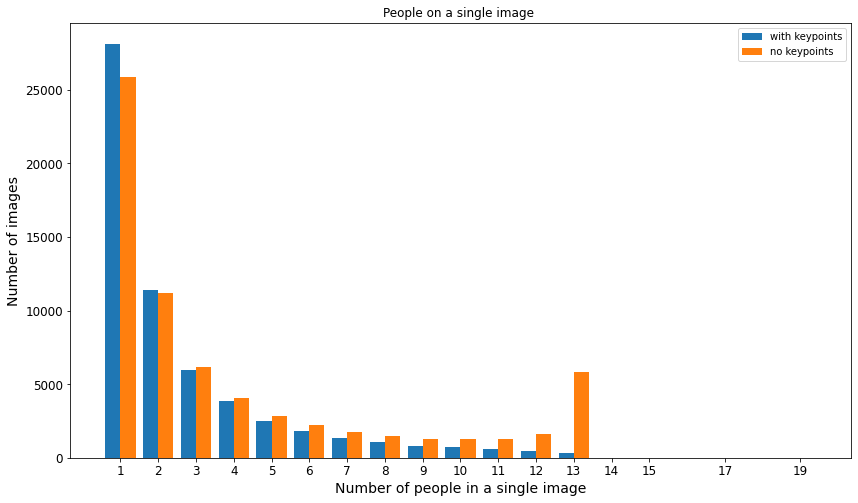

In [11]:
annotated_persons_nokp_df = coco_df[(coco_df['is_crowd'] == 0) & (coco_df['num_keypoints'] == 0)]
annotated_persons_kp_df = coco_df[(coco_df['is_crowd'] == 0) & (coco_df['num_keypoints'] > 0)]

print("Number of people (with keypoints) in total: " + str(len(annotated_persons_kp_df)))
print("Number of people without any keypoints in total: " + str(len(annotated_persons_nokp_df)))

persons_in_img_kp_df = pd.DataFrame({
    'cnt': annotated_persons_kp_df[['path','source']].value_counts()
})
persons_in_img_kp_df.reset_index(level=[0,1], inplace=True) 
persons_in_img_cnt_df = persons_in_img_kp_df.groupby(['cnt']).count()
x_occurences_kp = persons_in_img_cnt_df.index.values
y_images_kp = persons_in_img_cnt_df['path'].values

f = plt.figure(figsize=(14, 8))
width = 0.4
plt.bar(x_occurences_kp, y_images_kp, width=width, label='with keypoints')
plt.bar(x_occurences + width, y_images, width=width, label='no keypoints')

plt.title('People on a single image ')
plt.xticks(x_occurences + width/2, x_occurences)
plt.xlabel('Number of people in a single image')
plt.ylabel('Number of images')
plt.legend(loc = 'best')
plt.show()

Show a few examples of images with 13 annotated persons having at least 1 keypoint

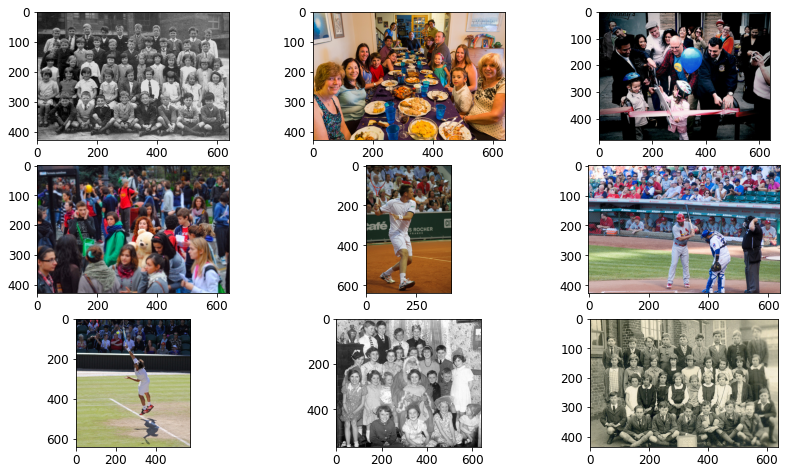

,path,source,cnt
23,000000250282.jpg,1,13
28,000000018380.jpg,1,13
34,000000005001.jpg,1,13
54,000000012670.jpg,1,13
73,000000410496.jpg,1,13
96,000000217285.jpg,1,13
127,000000493905.jpg,1,13
132,000000489842.jpg,1,13
137,000000390555.jpg,1,13


In [12]:
subset_df = persons_in_img_kp_df[(persons_in_img_kp_df['cnt'] == 13) & (persons_in_img_kp_df['source'] == 1)]

# take only 9 images -> grid 3x3

subset_df = subset_df[:9]

# read images

full_paths = [get_full_path(subset_df, row = r) for r in range(len(subset_df))]
imgs = [mpimg.imread(path) for path in full_paths]

# plot

_, axs = plt.subplots(3, 3, figsize=(14, 8))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

subset_df

### Add extra attributes to dataframe

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class AttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, num_keypoints, w_ix, h_ix, bbox_ix, kp_ix):
        self.num_keypoints = num_keypoints
        self.w_ix = w_ix
        self.h_ix = h_ix
        self.bbox_ix = bbox_ix
        self.kp_ix = kp_ix
    
    def fit(self, X, y=None):
        return self  # nothing else to do    
    
    def transform(self, X): 
        
        # retrieve specific columns
        
        w = X[:, self.w_ix] 
        h = X[:, self.h_ix]
        bbox = np.array(X[:, self.bbox_ix].tolist())
        keypoints = np.array(X[:, self.kp_ix].tolist())
        
        # calculate scale factors for bounding boxes
        
        scale_x = bbox[:,2] / w   
        scale_y = bbox[:,3] / h           
        aspect_ratio = w / h
        
        # categorize scales into 4 buckets S,M,L,XL. scale factor = 0.4 means that height of a bounding box 
        # takes 40% of a total height of an image and will be put into the bucket 'S'
        scale_cat = pd.cut(scale_y,
                                bins=[0., 0.4, 0.6, 0.8, np.inf],
                                labels=['S', 'M', 'L', 'XL']) # 0-0.4  0.4-0.6  0.6-0.8  0.8-1
                    
        return np.c_[X, scale_x, scale_y, scale_cat, aspect_ratio, keypoints] 

# get number of keypoints and column indexes    

num_keypoints = 17 
w_ix = coco_df.columns.get_loc('width') 
h_ix = coco_df.columns.get_loc('height') 
bbox_ix = coco_df.columns.get_loc('bbox') 
kp_ix = coco_df.columns.get_loc('keypoints')

# transformer object that is used to add new columns

attr_adder = AttributesAdder(
    num_keypoints=num_keypoints,
    w_ix = w_ix, 
    h_ix = h_ix, 
    bbox_ix = bbox_ix, 
    kp_ix = kp_ix)
coco_extra_attribs = attr_adder.transform(coco_df.values)

# determine column nmaes for keypoints. In coco dataset each keypoint is represented by a triple x,y,v - coordinates x,y
# and visibility flag. Each value is extracted to a separate column in dataframe like x1,x2,v1,... etc
keypoints_cols = [['x'+str(idx), 'y'+str(idx), 'v'+str(idx)] for idx, k in enumerate(range(num_keypoints))]
keypoints_cols = np.concatenate(keypoints_cols).tolist()

# crate a new richer dataframe

coco_extra_attribs_df = pd.DataFrame(
    coco_extra_attribs,
    columns=list(coco_df.columns)+["scale_x", "scale_y", "scale_cat", "aspect_ratio"] + keypoints_cols,
    index=coco_df.index)

coco_extra_attribs_df.head()

,path,width,height,is_crowd,bbox,area,num_keypoints,keypoints,source,scale_x,...,v13,x14,y14,v14,x15,y15,v15,x16,y16,v16
0,000000000036.jpg,481,640,0,"[167.58, 162.89, 310.61, 465.19]",86145.3,13,"[250, 244, 2, 265, 223, 2, 235, 235, 2, 309, 2...",0,0.645759,...,0,0,0,0,0,0,0,0,0,0
1,000000000049.jpg,381,500,0,"[203.39, 260.43, 65.69, 73.04]",1754.82,13,"[251, 276, 2, 253, 275, 2, 250, 274, 2, 259, 2...",0,0.172415,...,2,0,0,0,217,322,2,0,0,0
2,000000000049.jpg,381,500,0,"[118.43, 261.32, 56.91, 62.93]",1349.98,11,"[158, 270, 1, 160, 269, 2, 157, 269, 1, 167, 2...",0,0.14937,...,2,0,0,0,132,319,2,0,0,0
3,000000000049.jpg,381,500,0,"[119.34, 334.21, 11.94, 33.57]",250.82,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0.0313386,...,0,0,0,0,0,0,0,0,0,0
4,000000000049.jpg,381,500,0,"[284.34, 333.4, 10.88, 27.43]",162.9,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0.0285564,...,0,0,0,0,0,0,0,0,0,0


### Where are the noses in images

In [14]:
# only horizontal images to normalize keypoints coordinates
horiz_imgs_df = coco_extra_attribs_df[coco_extra_attribs_df['aspect_ratio'] >= 1.]

# get the mean width and height - used to scale keypoint coordinates

avg_w = int(horiz_imgs_df['width'].mean())
avg_h = int(horiz_imgs_df['height'].mean())

# indexes of required columns

w_ix = horiz_imgs_df.columns.get_loc('width') 
h_ix = horiz_imgs_df.columns.get_loc('height') 
x1_ix = horiz_imgs_df.columns.get_loc('x0') # x coord of a nose is the column 'x0'
y1_ix = horiz_imgs_df.columns.get_loc('y0') # y coord of a nose is the column 'y0'
v1_ix = horiz_imgs_df.columns.get_loc('v0') 

print ("avg width " + str(avg_w))
print ("avg height " + str(avg_h))

class NoseAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, avg_w, avg_h, w_ix, h_ix, x1_ix, y1_ix, v1_ix):
        self.avg_w = avg_w
        self.avg_h = avg_h
        self.w_ix = w_ix 
        self.h_ix = h_ix 
        self.x1_ix = x1_ix
        self.y1_ix = y1_ix
        self.v1_ix = v1_ix
    
    def fit(self, X, y=None):
        return self  # nothing else to do    
    
    def transform(self, X):
        w = X[:, self.w_ix] 
        h = X[:, self.h_ix]         
        x1 = X[:, self.x1_ix] 
        y1 = X[:, self.y1_ix]

        # normalize nose coords to the given global width, height
        
        scale_x = self.avg_w / w
        scale_y = self.avg_h / h                
        nose_x = x1 * scale_x
        nose_y = y1 * scale_y
                            
        return np.c_[X, nose_x, nose_y]

# transformer object that is used to add normalized nose coordinates columns

attr_adder = NoseAttributesAdder(
    avg_w = avg_w, 
    avg_h = avg_h,
    w_ix = w_ix, 
    h_ix = h_ix, 
    x1_ix = x1_ix, 
    y1_ix = y1_ix, 
    v1_ix = v1_ix
)
coco_noses = attr_adder.transform(horiz_imgs_df.values)

# crate dataframe with new normalized coordinates

coco_noses_df = pd.DataFrame(
    coco_noses,
    columns=list(horiz_imgs_df.columns) + ["normalized_nose_x", "normalized_nose_y"],
    index=horiz_imgs_df.index)

# get only subset of columns

coco_noses_df = coco_noses_df[["path", "source", "x0", "y0", "v0", "normalized_nose_x", "normalized_nose_y"]]

# filtering - only visible noses

coco_noses_df = coco_noses_df[coco_noses_df["v0"] == 2]
coco_noses_df.head()

avg width 622
avg height 439


,path,source,x0,y0,v0,normalized_nose_x,normalized_nose_y
27,000000000110.jpg,0,459,91,2,446.091,83.2271
28,000000000110.jpg,0,67,251,2,65.1156,229.56
31,000000000110.jpg,0,169,47,2,164.247,42.9854
32,000000000110.jpg,0,110,46,2,106.906,42.0708
36,000000000110.jpg,0,349,9,2,339.184,8.23125


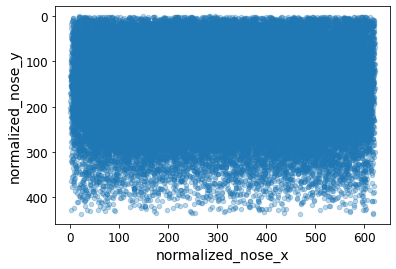

In [15]:
coco_noses_df.plot(kind="scatter", x="normalized_nose_x", y="normalized_nose_y", alpha=0.3).invert_yaxis()

Checkout images with noses at the bottom of an image - something unusual

In [16]:
low_noses_df = coco_noses_df[coco_noses_df['normalized_nose_y'] > 430 ]
low_noses_df

,path,source,x0,y0,v0,normalized_nose_x,normalized_nose_y
2443,000000005508.jpg,0,176,472,2,171.05,431.683
3923,000000008593.jpg,0,497,373,2,618.268,435.497
20083,000000044054.jpg,0,407,474,2,395.553,433.512
20821,000000045537.jpg,0,636,478,2,618.113,437.171
27054,000000059170.jpg,0,94,418,2,91.3563,430.756
38550,000000084784.jpg,0,181,475,2,175.909,434.427
55451,000000122818.jpg,0,261,477,2,253.659,436.256
70322,000000156135.jpg,0,255,421,2,247.828,434.868
134390,000000299786.jpg,0,588,420,2,571.462,432.817
151556,000000336221.jpg,0,251,472,2,243.941,431.683


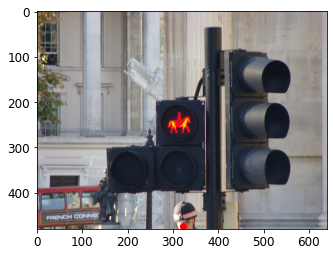

In [17]:
path = '000000289222.jpg'
source = 1
selected = low_noses_df[(low_noses_df['path'] == path) & (low_noses_df['source'] == source)]

full_path = get_full_path(selected)
img = mpimg.imread(full_path)
plt.imshow(img)
plt.plot(selected['x0'], selected['y0'], 'ro')

### Number of keypoints

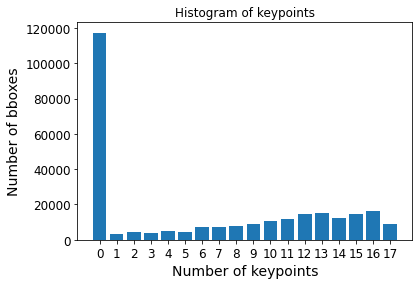

,Num keypoints %
0,0.428948
1,0.012466
2,0.015369
3,0.013559
4,0.018225
5,0.017073
6,0.026668
7,0.025838
8,0.028881
9,0.032384


In [18]:
y_images = coco_extra_attribs_df['num_keypoints'].value_counts()
x_keypoints = y_images.index.values

# plot

plt.figsize=(10,5)
plt.bar(x_keypoints, y_images)
plt.title('Histogram of keypoints')
plt.xticks(x_keypoints)
plt.xlabel('Number of keypoints')
plt.ylabel('Number of bboxes')
plt.show()

# percentage of images (column) with a number of keypoints (rows)

kp_df = pd.DataFrame({
    "Num keypoints %": coco_extra_attribs_df["num_keypoints"].value_counts() / len(coco_extra_attribs_df)
}).sort_index()
kp_df

### Scales

In [19]:
coco_extra_attribs_df.head()

,path,width,height,is_crowd,bbox,area,num_keypoints,keypoints,source,scale_x,...,v13,x14,y14,v14,x15,y15,v15,x16,y16,v16
0,000000000036.jpg,481,640,0,"[167.58, 162.89, 310.61, 465.19]",86145.3,13,"[250, 244, 2, 265, 223, 2, 235, 235, 2, 309, 2...",0,0.645759,...,0,0,0,0,0,0,0,0,0,0
1,000000000049.jpg,381,500,0,"[203.39, 260.43, 65.69, 73.04]",1754.82,13,"[251, 276, 2, 253, 275, 2, 250, 274, 2, 259, 2...",0,0.172415,...,2,0,0,0,217,322,2,0,0,0
2,000000000049.jpg,381,500,0,"[118.43, 261.32, 56.91, 62.93]",1349.98,11,"[158, 270, 1, 160, 269, 2, 157, 269, 1, 167, 2...",0,0.14937,...,2,0,0,0,132,319,2,0,0,0
3,000000000049.jpg,381,500,0,"[119.34, 334.21, 11.94, 33.57]",250.82,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0.0313386,...,0,0,0,0,0,0,0,0,0,0
4,000000000049.jpg,381,500,0,"[284.34, 333.4, 10.88, 27.43]",162.9,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0.0285564,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

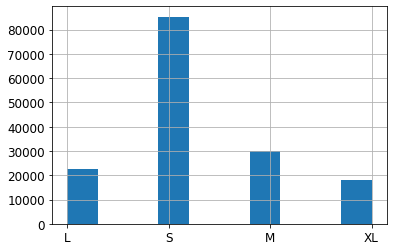

In [20]:
persons_df = coco_extra_attribs_df[coco_extra_attribs_df['num_keypoints'] > 0]
persons_df['scale_cat'].hist()

In [21]:
scales_props_df = pd.DataFrame({
    "Scales %": persons_df["scale_cat"].value_counts() / len(persons_df)
})
scales_props_df

,Scales %
S,0.546160
M,0.193187
L,0.145705
XL,0.114949


### Is COCO train and validation data stratified?

Strata: scales

In [22]:
persons_df = coco_extra_attribs_df[coco_extra_attribs_df['num_keypoints'] > 0]
train_df = persons_df[persons_df['source'] == 0]
val_df = persons_df[persons_df['source'] == 1]

scales_props_df = pd.DataFrame({
    "Scales in train set %": train_df["scale_cat"].value_counts() / len(train_df),
    "Scales in val set %": val_df["scale_cat"].value_counts() / len(val_df)
})
scales_props_df["Diff 100%"] = 100 * np.absolute(scales_props_df["Scales in train set %"] - scales_props_df["Scales in val set %"])
scales_props_df

,Scales in train set %,Scales in val set %,Diff 100%
S,0.545340,0.565491,2.015133
M,0.193515,0.185453,0.806118
L,0.146176,0.134603,1.157229
XL,0.114970,0.114452,0.051785


Strata: number of keypoints

In [23]:
train_df = coco_extra_attribs_df[coco_extra_attribs_df['source'] == 0]
val_df = coco_extra_attribs_df[coco_extra_attribs_df['source'] == 1]

kp_props_df = pd.DataFrame({
    "Num keypoints in train set %": train_df["num_keypoints"].value_counts() / len(train_df),
    "Num keypoints in val set %": val_df["num_keypoints"].value_counts() / len(val_df)
}).sort_index()
kp_props_df["Diff 100%"] = 100 * np.absolute(kp_props_df["Num keypoints in train set %"] - kp_props_df["Num keypoints in val set %"])
kp_props_df

,Num keypoints in train set %,Num keypoints in val set %,Diff 100%
0,0.429208,0.422755,0.645234
1,0.012459,0.012632,0.017297
2,0.015354,0.015722,0.036713
3,0.013491,0.015176,0.168498
4,0.018128,0.020538,0.240985
5,0.016962,0.019720,0.275784
6,0.026579,0.028808,0.222892
7,0.025775,0.027354,0.157882
8,0.028869,0.029171,0.030260
9,0.032313,0.034079,0.176564
